In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import random
import string
import copy
import re
import numpy as np
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train = pd.read_csv("/content/drive/MyDrive/ml/irony_sarcasm_train.csv")
test = pd.read_csv("/content/drive/MyDrive/ml/irony_sarcasm_test.csv")

In [4]:
train['class'].value_counts()

figurative    21238
irony         20894
sarcasm       20681
regular       18595
Name: class, dtype: int64

In [5]:
test['class'].value_counts()

irony         2111
sarcasm       2105
figurative    2044
regular       1859
Name: class, dtype: int64

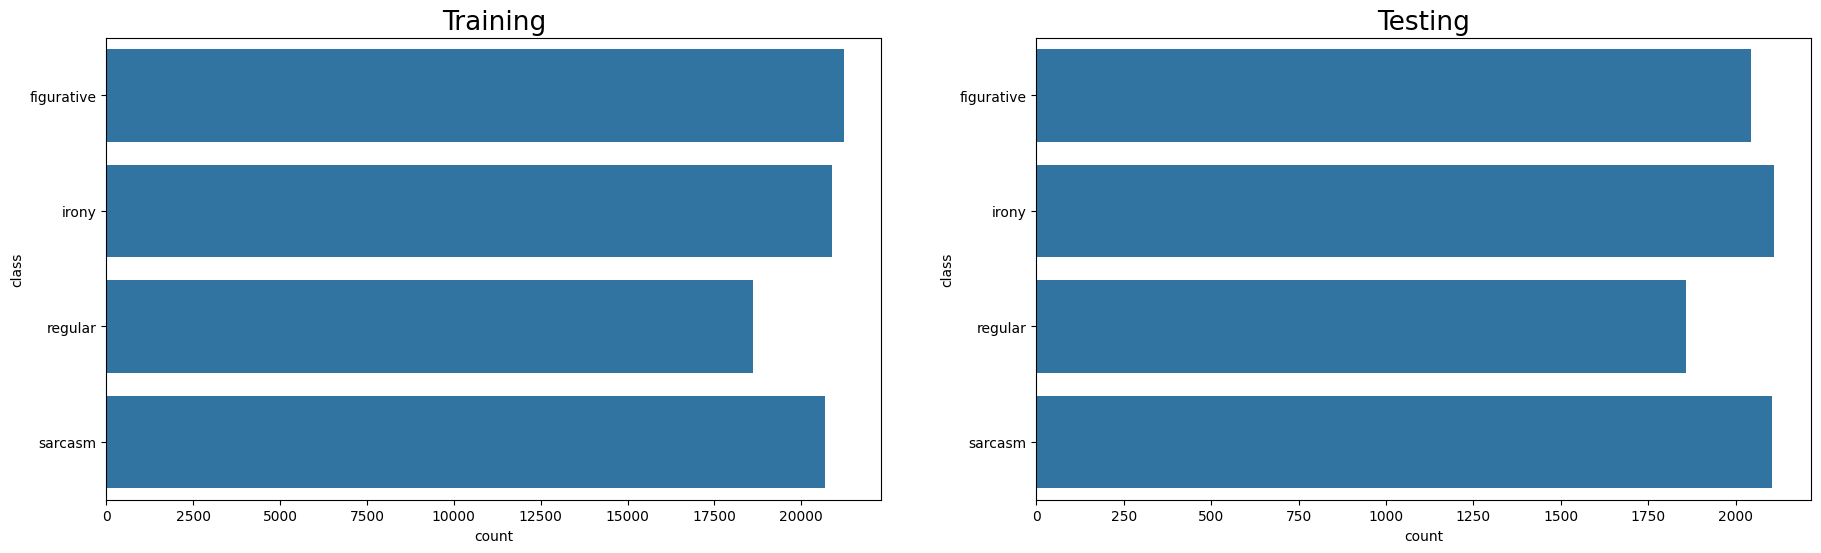

In [6]:
# train.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
# plt.gca().spines[['top', 'right',]].set_visible(False)
fig, ax = plt.subplots(1, 2, figsize=(22, 6))
sns.countplot(train['class'], ax = ax[0])
sns.countplot(test['class'], ax = ax[1])
ax[0].set_title('Training', size=19)
ax[1].set_title('Testing', size=19)
plt.show()

In [7]:
print(f'Shape of the training dataset is : {train.shape}')
print(f'Shape of the testing dataset is : {test.shape}')

Shape of the training dataset is : (81408, 2)
Shape of the testing dataset is : (8128, 2)


In [8]:
value_to_remove1='figurative'

In [9]:
train=train[train['class']!=value_to_remove1]
test=test[test['class']!=value_to_remove1]

In [10]:
value_to_remove2='regular'

In [11]:
train=train[train['class']!=value_to_remove2]
test=test[test['class']!=value_to_remove2]

In [12]:
train.head()
test.head()

,tweets,class
70,Oh Scotland's only conservative MP is only a f...,NaN
971,I love going to work,NaN
2046,@BBCTalkback nhs nurse hurts shoulder in work ...,irony
2047,@jeffmeintzer @FoxNews @fxnscitech well wouldn...,irony
2048,#IRONY Funny How more media reporters cover th...,irony


In [13]:
# let's check for the null values in dataste
print(f'Null values : \n{train.isna().sum()}')
print(f'Null values : \n{test.isna().sum()}')

Null values : 
tweets    0
class     0
dtype: int64
Null values : 
tweets    2
class     9
dtype: int64


In [14]:
test.dropna(axis=0, inplace=True)

<ipython-input-14-ca929d0d286a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.dropna(axis=0, inplace=True)


In [15]:
# let's check again the null values
print(f'Null values : \n{test.isna().sum()}')

Null values : 
tweets    0
class     0
dtype: int64


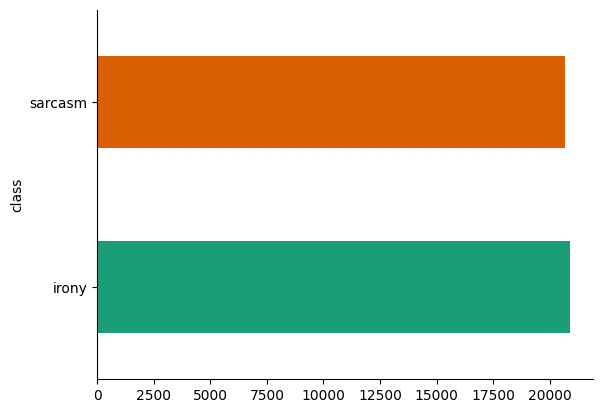

In [16]:
# @title class
train.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [17]:
# train=train.dropna(subset=['tweets','class'])
# test=test.dropna(subset=['tweets','class'])

In [18]:
stopwordlist = ['a','about','above', 'after', 'again', 'ain', 'all', 'am', 'an', 'also',
                        'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
                        'being', 'below', 'between','both', 'by', 'but','can', 'cant',"can\'","cannot", 'd', 'did', 'do','dont', "don\'",
                        'does', 'doing', 'down', 'during', 'each','even','few', 'for', 'from',
                        'further', 'get','had', 'has', 'have', 'having', 'he', 'her', 'here',
                        'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
                        'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma','make','made',
                        'me', 'more', 'most','my', 'must','myself', 'now', 'not',"didn\'",'o', 'of', 'on', 'once', 'one',
                        'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such', 'still',
                        't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
                        'themselves', 'then', 'there', 'these', 'they','this', 'those',
                        'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
                        'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
                        'why', 'will', 'with', 'won', 'would','y', 'you', "youd","youll", "youre",
                        "youve", 'your', 'yours', 'yourself', 'yourselves', '➡' ,'✌']

L1=copy.deepcopy(stopwordlist)
L=[word.capitalize() for word in L1]
stopwordlist.extend(L)

STOPWORDS = set(stopwordlist)
english_punctuations = string.punctuation
punctuations_list = english_punctuations

In [19]:
def cleaning_stopwords(text):
        return " ".join([word for word in str(text).split() if word not in STOPWORDS])
def cleaning_punctuations(text):
        translator = str.maketrans('', '', punctuations_list)
        return text.translate(translator)
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [20]:
train['tweets']=train['tweets'].apply(lambda text:cleaning_stopwords(text))
train['tweets']=train['tweets'].apply(lambda text:cleaning_punctuations(text))
train['tweets']=train['tweets'].apply(lambda text:deEmojify(text))

test['tweets']=test['tweets'].apply(lambda text:cleaning_stopwords(text))
test['tweets']=test['tweets'].apply(lambda text:cleaning_punctuations(text))
test['tweets']=test['tweets'].apply(lambda text:deEmojify(text))

In [21]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le = le.fit(train['class'])

In [22]:
labels = le.transform(train['class'])

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

In [24]:
texts_train = tfidf.fit_transform(train['tweets']).todense()

In [25]:
texts_train.shape

(41575, 76310)

In [26]:
# test_text = test['tweets'].apply(clean_text)
test_labels = le.transform(test['class'])

texts_test = tfidf.transform(test['tweets']).todense()

In [27]:
texts_test.shape

(4216, 76310)

In [ ]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)
classifier_rf.fit(np.asarray(texts_train),labels)


In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(np.asarray(texts_train), labels)

In [ ]:
NBclassifier=MultinomialNB()
NBclassifier.fit(np.asarray(texts_train),labels)

In [ ]:
# accuracy1 = accuracy_score(y_test, y_pred1)
# print(f'Accuracy: {accuracy1}')
print(classification_report(test_labels, classifier_rf.predict(texts_test)))

In [ ]:
# accuracy2 = accuracy_score(y_test, y_pred2)
# print(f'Accuracy: {accuracy2}')
print(classification_report(test_labels,LRmodel.predict(texts_test)))

In [ ]:
# accuracy3 = accuracy_score(y_test, y_pred3)
# print(f'Accuracy: {accuracy3}')
print(classification_report(test_labels, NBclassifier.predict(texts_test)))

In [ ]:
confusion_mat1 = confusion_matrix(test_labels, classifier_rf.predict(texts_test))
print(confusion_mat1)

In [ ]:
confusion_mat_values1=confusion_mat1.flatten()
print(confusion_mat_values1)

In [ ]:
confusion_mat2 = confusion_matrix(test_labels, LRmodel.predict(texts_test))
print(confusion_mat2)

In [ ]:
confusion_mat_values2=confusion_mat2.flatten()
print(confusion_mat_values2)

In [ ]:
confusion_mat3 = confusion_matrix(test_labels, NBClassifier.predict(texts_test))
print(confusion_mat3)

In [ ]:
confusion_mat_values3=confusion_mat3.flatten()
print(confusion_mat_values3)

In [ ]:
categories = ['Irony','Sarcasm']
group_names = ['True Irony', 'False Sarcasm', 'False Irony', 'True Sarcasm']
group_percentages = ['{0:.2%}'.format(value) for value in confusion_mat1.flatten() / np.sum(confusion_mat1)]
labels = [f'{v1} {v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_mat1, annot = labels, cmap = 'Blues',fmt = '',
xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [ ]:
categories = ['Irony','Sarcasm']
group_names = ['True Irony', 'False Sarcasm', 'False Irony', 'True Sarcasm']
group_percentages = ['{0:.2%}'.format(value) for value in confusion_mat2.flatten() / np.sum(confusion_mat2)]
labels = [f'{v1} {v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_mat2, annot = labels, cmap = 'Blues',fmt = '',
xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [ ]:
categories = ['Irony','Sarcasm']
group_names = ['True Irony', 'False Sarcasm', 'False Irony', 'True Sarcasm']
group_percentages = ['{0:.2%}'.format(value) for value in confusion_mat3.flatten() / np.sum(confusion_mat3)]
labels = [f'{v1} {v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_mat3, annot = labels, cmap = 'Blues',fmt = '',
xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)